<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-loading" data-toc-modified-id="Data-loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data loading</a></span><ul class="toc-item"><li><span><a href="#Tropopause" data-toc-modified-id="Tropopause-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Tropopause</a></span></li><li><span><a href="#LWA" data-toc-modified-id="LWA-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>LWA</a></span></li><li><span><a href="#Stat.-significance" data-toc-modified-id="Stat.-significance-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Stat. significance</a></span></li></ul></li><li><span><a href="#Figure-3" data-toc-modified-id="Figure-3-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Figure 3</a></span></li></ul></div>

In [43]:
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import shapely.geometry as sgeom
from matplotlib.ticker import FuncFormatter

%matplotlib inline

In [3]:
%reload_ext watermark
%watermark --iversions -v -m

numpy      1.17.3
matplotlib 3.1.2
xarray     0.16.0
CPython 3.6.9
IPython 7.1.1

compiler   : GCC 8.4.0
system     : Linux
release    : 4.15.0-122-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [5]:
timescale = 20
DJF_bool = '_DJFonly'
cesta = '/mnt/4data/CMAM/0A.daily/composites_woSSW{}/'.format(DJF_bool)

# Data loading

## Tropopause

In [15]:
infile_name = '{}{}_{}_comp_*_{}days.nc'.format(cesta, 'ptrop', 'absolute', 20)
infiles = glob.glob(infile_name)
e_types = list(map(lambda x: x.split('comp_')[1].split('_{}days'.format(timescale))[0], infiles))
da_trop =  xr.open_mfdataset(infiles, concat_dim='e_type', combine = 'nested')
da_trop['e_type'] = e_types
da_trop['ptrop'] = da_trop.ptrop/100.
da_trop

<xarray.Dataset>
Dimensions:  (e_type: 3, lag: 21, lat: 48, lon: 96)
Coordinates:
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lag      (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * e_type   (e_type) <U9 'himalayas' 'westamer' 'eastasia'
Data variables:
    ptrop    (e_type, lag, lat, lon) float64 dask.array<chunksize=(1, 21, 48, 96), meta=np.ndarray>

## LWA

In [19]:
var_ls = ['lwatend_logH']
e_type_ls = ['himalayas', 'eastasia', 'westamer']
what_ls = ['anomalies','absolute']
da_ls2 = []

for what in what_ls:
    da_ls = []
    print(what)
    for i,e_type in enumerate(e_type_ls):
        print(e_type)
        ds_ls = []
        for var in var_ls:
            ds = xr.open_dataset(f'{cesta}{var}_{what}_comp_{e_type}_{timescale}days.nc')
            if var not in ['lwa','sink', 'lwatend_logH']:
                ds['plev'] = ds.plev/100.
            else:
                ds = ds.rename({'z': 'plev'})
            ds_ls.append(ds)
        da = xr.merge(ds_ls)

        da_ls.append(da)
    da_conc = xr.concat(da_ls, dim = 'e_type')
    da_conc['e_type'] = e_type_ls
    da_ls2.append(da_conc)
        
da_all = xr.concat(da_ls2, dim = 'what')
da_all['what'] = what_ls
da_all

anomalies
himalayas
eastasia
westamer
absolute
himalayas
eastasia
westamer


<xarray.Dataset>
Dimensions:  (e_type: 3, lag: 21, lat: 48, lon: 96, plev: 39, what: 2)
Coordinates:
  * e_type   (e_type) <U9 'himalayas' 'eastasia' 'westamer'
  * plev     (plev) float64 2e+03 4e+03 6e+03 8e+03 ... 7.4e+04 7.6e+04 7.8e+04
  * lag      (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15.0 ... 345.0 348.8 352.5 356.2
  * what     (what) <U9 'anomalies' 'absolute'
Data variables:
    lwatend  (what, e_type, lag, plev, lat, lon) float64 1.183e-06 ... 0.0

## Stat. significance

In [12]:
#infile_name = '{3}{0}_pvalues_from{1}_comp_*_{2}days_zm.nc'.format(var, 10000, timescale, cesta)
var = 'lwatend'#'sink'
infile_name = '{3}{0}_pvalues_from{1}_comp_*_{2}days.nc'.format(var, 10000, timescale, cesta)
print(infile_name)
infiles = glob.glob(infile_name)
comp_types = list(map(lambda x: x.split('comp_')[1].split('_{}days'.format(timescale))[0], infiles))
print(comp_types)
print(infiles)
print()
ds_p = xr.open_mfdataset(infiles, concat_dim='e_type', combine ='nested')
ds_p['e_type'] = comp_types
if var not in ['lwa','sink','lwatend']:
    ds_p['plev'] = ds_p.plev/100.
else:
    ds_p = ds_p.rename({'z': 'plev'})
ds_p

/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/lwatend_pvalues_from10000_comp_*_20days.nc
['himalayas', 'eastasia', 'westamer']
['/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/lwatend_pvalues_from10000_comp_himalayas_20days.nc', '/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/lwatend_pvalues_from10000_comp_eastasia_20days.nc', '/mnt/4data/CMAM/0A.daily/composites_woSSW_DJFonly/lwatend_pvalues_from10000_comp_westamer_20days.nc']



<xarray.Dataset>
Dimensions:  (e_type: 3, lag: 21, lat: 48, plev: 39)
Coordinates:
  * plev     (plev) float64 2e+03 4e+03 6e+03 8e+03 ... 7.4e+04 7.6e+04 7.8e+04
  * lat      (lat) float64 -87.16 -83.48 -79.78 -76.07 ... 79.78 83.48 87.16
  * lag      (lag) int64 -10 -9 -8 -7 -6 -5 -4 -3 -2 -1 0 1 2 3 4 5 6 7 8 9 10
  * e_type   (e_type) <U9 'himalayas' 'eastasia' 'westamer'
Data variables:
    lwatend  (e_type, plev, lat, lag) float64 dask.array<chunksize=(1, 39, 48, 21), meta=np.ndarray>

# Figure 3

In [187]:
def thousands(x, pos):
    return '%g' % (x*1e-3)

p0=1013.25
H = 7000
def press2height(x):
    return H*np.log(p0/x)
      
def height2press(x):
    return p0*np.exp(-x/H)

lwatend_anomalies_all_20days_zm_wsignificance_DJFonly.pdf


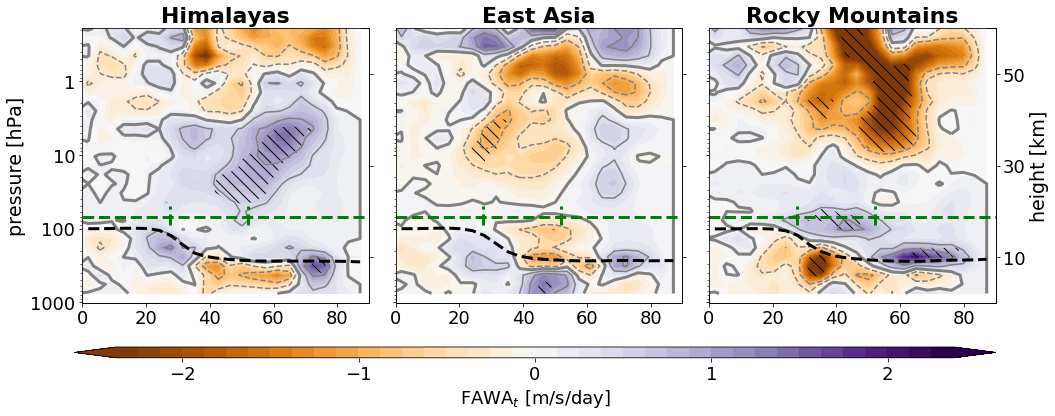

In [235]:
levels= np.linspace(-2.5,2.5,41)
cbar_label = f'FAWA$_t$ [m/s/day]'
titles = ['Himalayas', 'East Asia', 'Rocky Mountains'] #'West America']
label_ls = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']
cmap = mpl.cm.PuOr#RdBu_r
mpl.rcParams.update({'font.size': 18})

plot_arr = da_all['lwatend'].sel(what = what_ls[0], lag = 0, plev = slice(None,60000)).mean('lon')*scale
p = xr.plot.FacetGrid(plot_arr, col = 'e_type', size = 5)

da_trop2 = da_trop.ptrop.sel(lag=0, lat = slice(0,None)).mean('lon')
lats = p.data.lat.values
levs = p.data.plev.values
plot_arr = da_all['lwatend'].sel(what = what_ls[1], lag = 0, plev = slice(None,60000)).mean('lon')*scale

for i,(ax, sel_dict, label) in enumerate(zip(p.axes.flat, p.name_dicts.flat, label_ls)):
    ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize = 20, 
              fontweight='bold', va='top', bbox={'alpha': 0.7, 'facecolor': 'white'})
    #da_trop2.sel(**sel_dict).plot.line('k--', ax = ax, lw = 3, zorder = 20)
    
    if i==0:
        ax.set_ylabel('pressure [hPa]', fontsize = 19)
    else:
        ax.set_ylabel('')
    
    ax.set_yscale('log')
    #ax.get_shared_y_axes()
    ax.axis([0, 90, height2press(0), height2press(60000)])
    ax.set_yticks([1000,100,10,1])   
    fmt = mpl.ticker.FormatStrFormatter("%g")
    ax.yaxis.set_major_formatter(fmt)       
    
    ax2 = ax.twinx()
    # plot contourf of lwatend anomalies
    plot_kwargs = dict(ax = ax2, \
                   cmap = cmap, \
                   levels=levels, add_colorbar = False)
    p.data.sel(**sel_dict).plot.contourf(**plot_kwargs)
    # plot contour of lwatend absolute values (positive only)
    plot_kwargs = dict(ax = ax2,\
                   colors = '0.5', \
                   levels=levels2, add_colorbar=False, alpha =1)
    plot_arr.sel(**sel_dict).plot.contour(**plot_kwargs)
    # plot contour of lwatend absolute values (negative only)
    plot_kwargs['linestyles'] = 'dashed'
    plot_kwargs['levels'] = np.array(levels2)[::-1]*-1
    plot_arr.sel(**sel_dict).plot.contour(**plot_kwargs)
    # plot contour of lwatend absolute values (zero only)
    plot_kwargs['linestyles'] = 'solid'
    plot_kwargs['levels'] = lev0
    plot_kwargs['linewidths'] = 3
    plot_kwargs['alpha'] = 1
    plot_arr.sel(**sel_dict).plot.contour(**plot_kwargs)  
    # plot tropopause line
    press2height(da_trop2.sel(**sel_dict)).plot.line('k--', ax=ax2, lw = 3)
    # plot hotspot lines
    ax2.hlines(press2height(70),-20,90, color='g', ls='--', lw=3)
    ax2.vlines(list(box.bounds)[1::2],press2height(90),press2height(50), color='g', ls='--', lw=3)
    # plot stat. significance using hatching
    plot_kwargs = dict(levels = [0,0.05], hatches=['\\\\',None], \
                                colors='none', add_colorbar=False)
    sel_dict['plev'] = slice(None, 60000)
    sel_dict['lat'] = slice(-20,None)
    sel_dict['lag'] = 0
    ds_p['lwatend'].sel(**sel_dict).plot.contourf(**plot_kwargs)
    
    ax2.get_shared_y_axes()
    ax2.axis([0, 90, 0, 60000])
    ax2.set_yticks([10000,30000,50000])
    fmt = FuncFormatter(thousands)
    ax2.yaxis.set_major_formatter(fmt)
    
    if i != 2:
        ax2.set_yticklabels([])
        ax2.set_ylabel('')
    if i == 2:
        ax2.set_ylabel('height [km]', fontsize = 19)
    
    ax2.set_title(titles[i], fontdict=dict(fontweight = 'bold', fontsize = 22))  
    
    
p.fig.tight_layout()
p.fig.subplots_adjust(right=0.875)
cbar_ax = p.fig.add_axes([0.075, -0.03, .8, .03])
norm = mpl.colors.BoundaryNorm(levels[1:-1], cmap.N)
label = cbar_label
cb2 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap,  \
                                norm=norm, orientation='horizontal', \
                                boundaries=levels, extend='both',  label = cbar_label, \
                                ticks=[-2,-1,0,1,2], spacing='proportional')

outfile='{}_{}_{}_{}days_zm_wsignificance_DJFonly.pdf'.format('lwatend', what_ls[0], 'all', timescale)
print(outfile)
plt.savefig(outfile, dpi = 300, bbox_inches='tight')
    

